# Plot object features for different CSLs

In [2]:
from campa.tl import Experiment, FeatureExtractor, thresholded_count, thresholded_median
from campa.constants import EXPERIMENT_DIR
from campa.pl import hex2rgb, plot_object_stats
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
import pandas as pd
from copy import deepcopy

Reading config from /mnt/home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [3]:
exp = Experiment.from_dir('VAE_SBF2/CondVAE_siRNA-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed3_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs'][:-1]}

## explore area vs cajal body intensity

In [3]:
df = pd.concat([extr.adata.uns['object_stats'] for extr in list(extrs.values())], keys=list(extrs.keys()))
df = df.reset_index(level=0)
df = df.reset_index(drop=True)

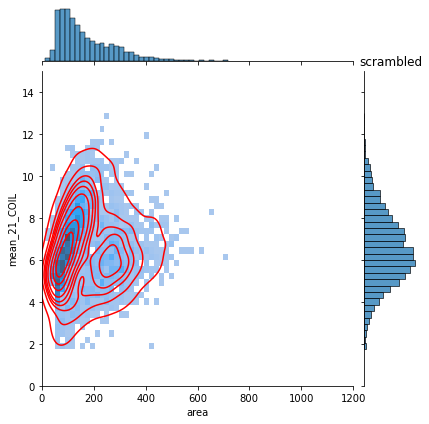

<Figure size 432x288 with 0 Axes>

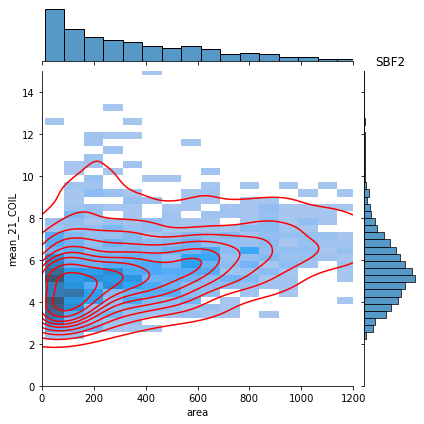

<Figure size 432x288 with 0 Axes>

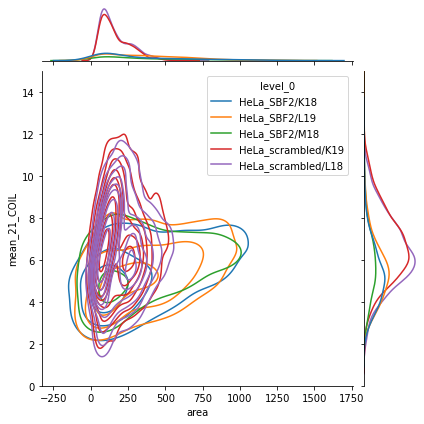

In [4]:
# Cajal bodies intensity vs size
cur_df = df[df['clustering'] == 'Cajal bodies']
# filter those objects with really large area
cur_df = cur_df[cur_df['area'] < np.quantile(cur_df['area'], 0.999)]
# filter ofjects with area < 10
cur_df = cur_df[cur_df['area'] > 10]
# filter objects with low intensity of COIL
cur_df = cur_df[(cur_df['mean_21_COIL'] > 5) | (cur_df['area'] > 50)]


g = sns.jointplot(data=cur_df[cur_df['level_0'].isin(['HeLa_scrambled/L18', 'HeLa_scrambled/K19'])], x="area", y="mean_21_COIL", ylim=[0,15], xlim=[0,1200], kind='hist')
g.plot_joint(sns.kdeplot, color="r")
plt.title('scrambled')
plt.figure()
g = sns.jointplot(data=cur_df[~cur_df['level_0'].isin(['HeLa_scrambled/L18', 'HeLa_scrambled/K19'])], x="area", y="mean_21_COIL", ylim=[0,15], xlim=[0,1200], kind='hist')
g.plot_joint(sns.kdeplot, color="r")
plt.title('SBF2')
plt.figure()
sns.jointplot(data=cur_df, x="area", y="mean_21_COIL", hue='level_0', ylim=[0,15], kind='kde')

## aggregate using additional thresholded

In [6]:
# aggregate object statistics, using additional thresholding
for extr in extrs.values():
    _ = extr.get_object_stats(area_threshold=10, agg=['median', thresholded_count, thresholded_median])
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

## Plot object stats with thresholded count + median
Maybe can find sth to filter them on?

- cajal bodies seem to be relatively small (for SBF2 cells) when there are many
- following experiments below, aggregate using thresholded_count which only counts large objects up to threshold % of total size.

In [10]:
agg_stats = adata_object_stats.obsm['object_stats_agg']
#agg_stats.columns = pd.MultiIndex.from_tuples([tuple(i.split("|")) for i in agg_stats.columns])
agg_stats['siRNA'] = adata_object_stats.obs['siRNA']

<AxesSubplot:xlabel="('count', 'Cajal bodies')", ylabel="('area_median', 'Cajal bodies')">

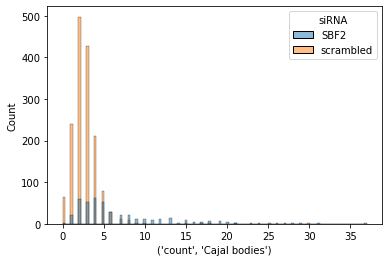

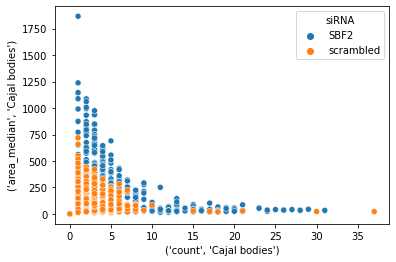

In [12]:
sns.histplot(data=agg_stats, x=('count', 'Cajal bodies'), hue='siRNA')
plt.figure()
sns.scatterplot(data=agg_stats, x=('count', 'Cajal bodies'), y=('area_median', 'Cajal bodies'), hue='siRNA')

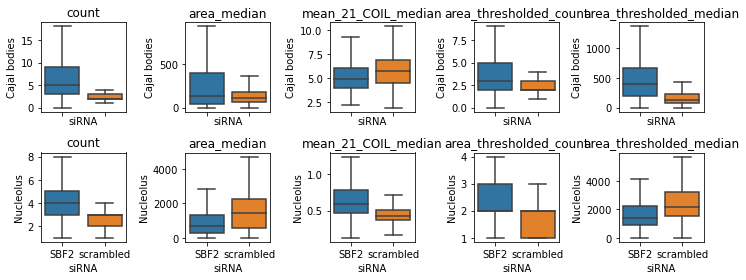

In [14]:
# areas < 10 filtered
plot_object_stats(adata_object_stats, 'siRNA', features=['count', 'area_median', 'mean_21_COIL_median', 'area_thresholded_count', 'area_thresholded_median'], 
                  clusters=['Cajal bodies', 'Nucleolus'], showfliers=False) #, 'Nucleolus'])



## Plot example cells showing need for filtering in the case of cajal bodies
TODO need to do suppl plots here!

In [15]:
# get mpp data
mpp_data = extrs['HeLa_SBF2/K18'].mpp_data
object_stats = extrs['HeLa_SBF2/K18'].adata.uns['object_stats']


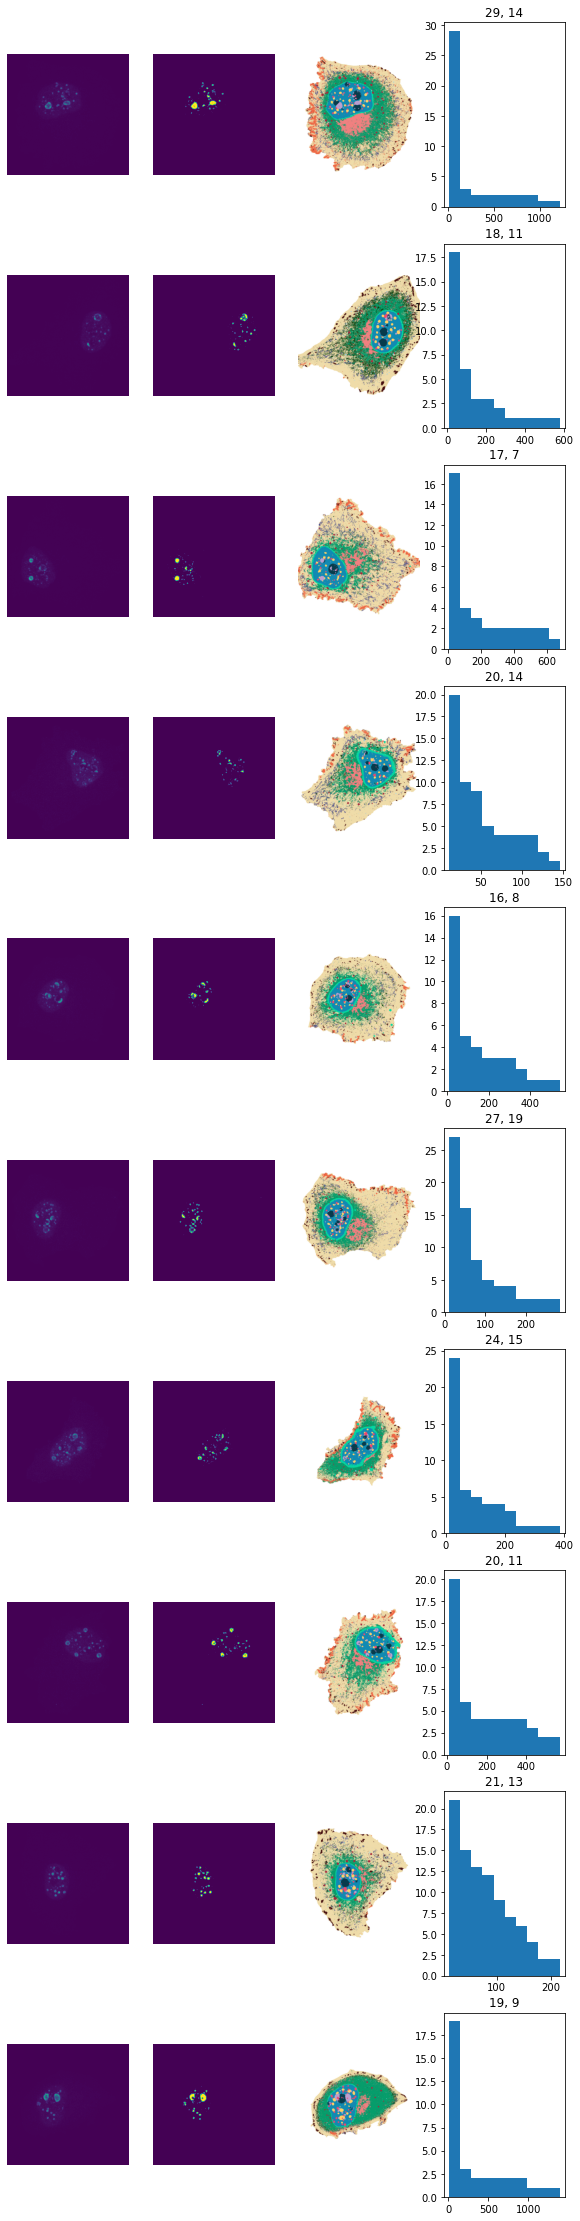

In [204]:
# plot cells with many cajal bodies
selected_cells = adata_object_stats_old.obs[['mapobject_id', 'well_name']][agg_stats['count']['Cajal bodies'] > 15]
fig, axes = plt.subplots(10,4, figsize=(10,40))
for i, obj_id in enumerate(selected_cells[selected_cells['well_name'] == 'K18']['mapobject_id'][:10]):
    intensity_img = mpp_data.get_object_img(int(obj_id), data='mpp', channel_ids=mpp_data.get_channel_ids(['21_COIL']), img_size=750)
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=750)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=750)
    axes[i,0].imshow(intensity_img[:,:,0])
    axes[i,0].axis('off')
    axes[i,1].imshow(cluster_img == 'Cajal bodies')
    axes[i,1].axis('off')
    axes[i,2].imshow(cluster_img_colored)
    axes[i,2].axis('off')
    # plot histogram of sizes
    mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == 'Cajal bodies') & (object_stats['area'] > 10)
    axes[i,3].set_title(f"{len(object_stats[mask]['area'])}, {object_stats[mask]['area'].agg(thresholded_count)}")
    axes[i,3].hist(object_stats[mask]['area'], cumulative=-1, density=False)

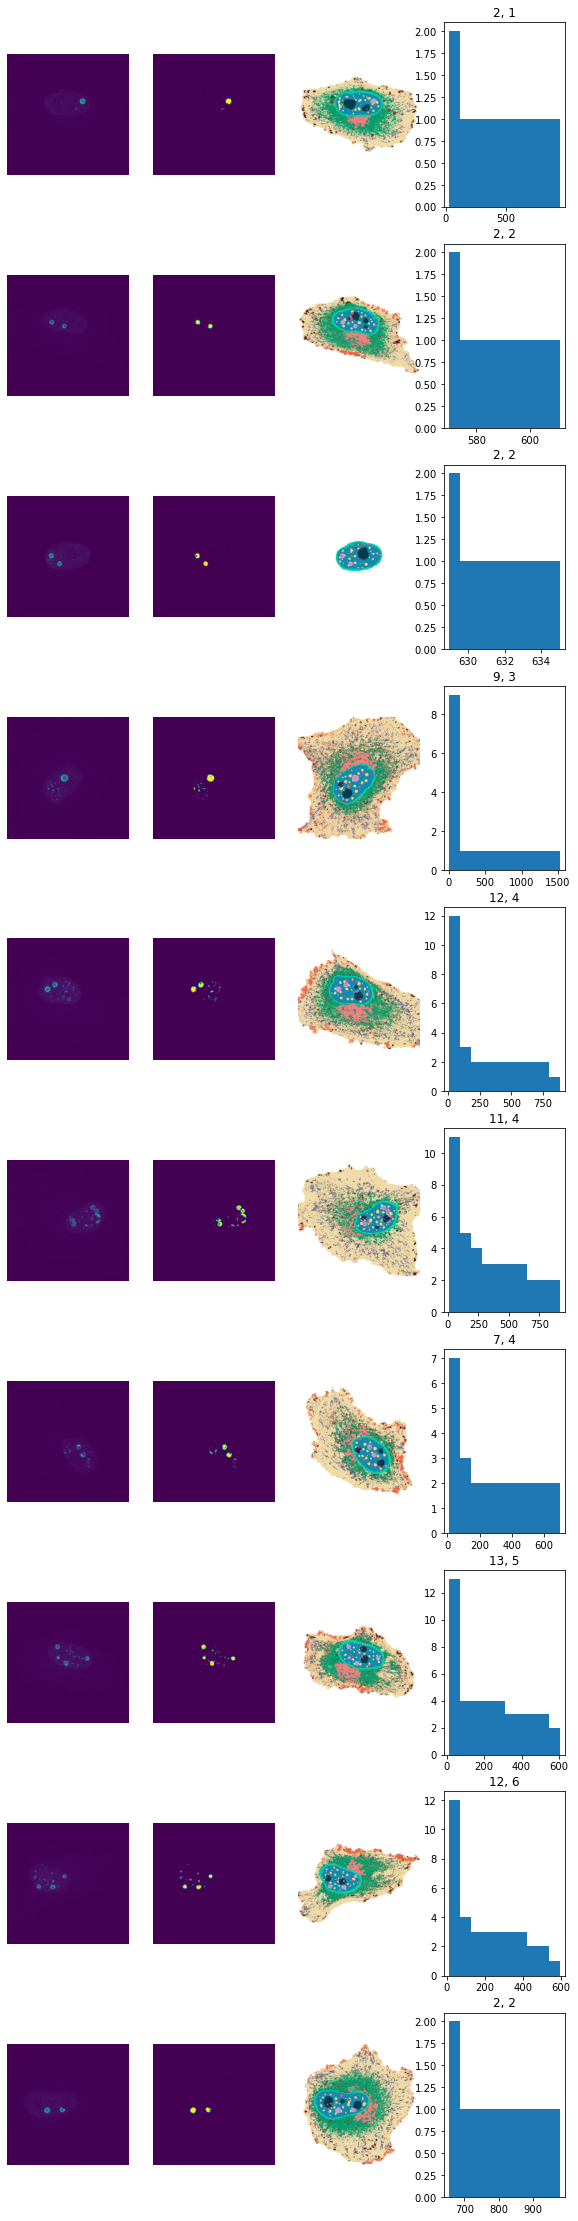

In [203]:
# plot cells with few cajal bodies
selected_cells = adata_object_stats_old.obs[['mapobject_id', 'well_name']][agg_stats['count']['Cajal bodies'] < 15]
fig, axes = plt.subplots(10,4, figsize=(10,40))
for i, obj_id in enumerate(selected_cells[selected_cells['well_name'] == 'K18']['mapobject_id'][:10]):
    intensity_img = mpp_data.get_object_img(int(obj_id), data='mpp', channel_ids=mpp_data.get_channel_ids(['21_COIL']), img_size=750)
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=750)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=750)
    axes[i,0].imshow(intensity_img[:,:,0])
    axes[i,0].axis('off')
    axes[i,1].imshow(cluster_img == 'Cajal bodies')
    axes[i,1].axis('off')
    axes[i,2].imshow(cluster_img_colored)
    axes[i,2].axis('off')
    # plot histogram of sizes
    mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == 'Cajal bodies') & (object_stats['area'] > 10)
    axes[i,3].set_title(f"{len(object_stats[mask]['area'])}, {object_stats[mask]['area'].agg(thresholded_count)}")
    axes[i,3].hist(object_stats[mask]['area'], cumulative=-1, density=False)

In [206]:
# for comparison, plot some cells from scrambled
# get mpp data
mpp_data = extrs['HeLa_scrambled/K19'].mpp_data
object_stats = extrs['HeLa_scrambled/K19'].adata.uns['object_stats']

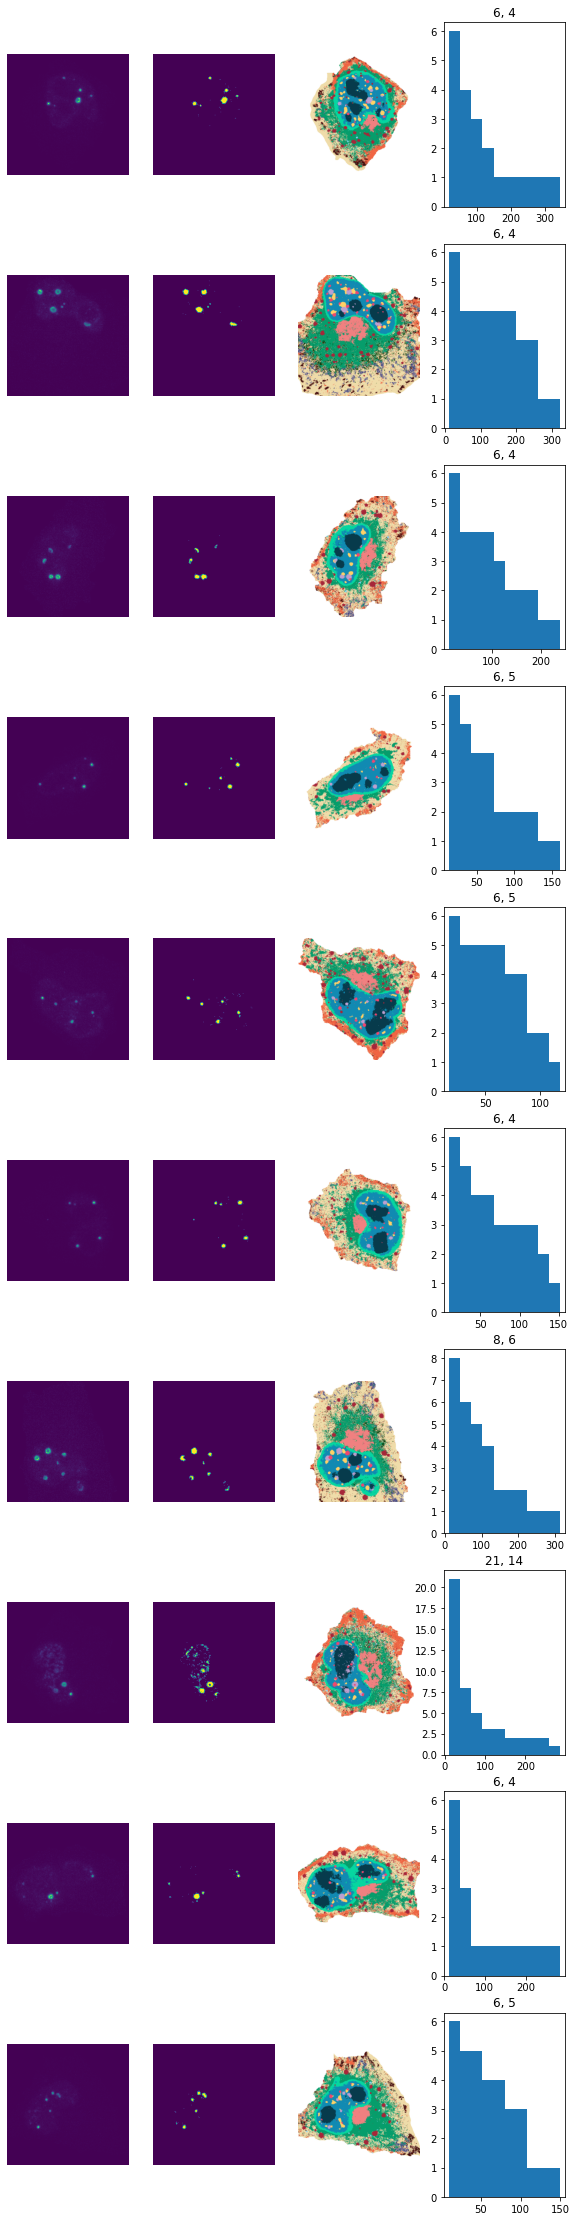

In [208]:
# plot cells with many cajal bodies
selected_cells = adata_object_stats_old.obs[['mapobject_id', 'well_name']][agg_stats['count']['Cajal bodies'] > 5]
fig, axes = plt.subplots(10,4, figsize=(10,40))
for i, obj_id in enumerate(selected_cells[selected_cells['well_name'] == 'K19']['mapobject_id'][:10]):
    intensity_img = mpp_data.get_object_img(int(obj_id), data='mpp', channel_ids=mpp_data.get_channel_ids(['21_COIL']), img_size=400)
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=400)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=400)
    axes[i,0].imshow(intensity_img[:,:,0])
    axes[i,0].axis('off')
    axes[i,1].imshow(cluster_img == 'Cajal bodies')
    axes[i,1].axis('off')
    axes[i,2].imshow(cluster_img_colored)
    axes[i,2].axis('off')
    # plot histogram of sizes
    mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == 'Cajal bodies') & (object_stats['area'] > 10)
    axes[i,3].set_title(f"{len(object_stats[mask]['area'])}, {object_stats[mask]['area'].agg(thresholded_count)}")
    axes[i,3].hist(object_stats[mask]['area'], cumulative=-1, density=False)

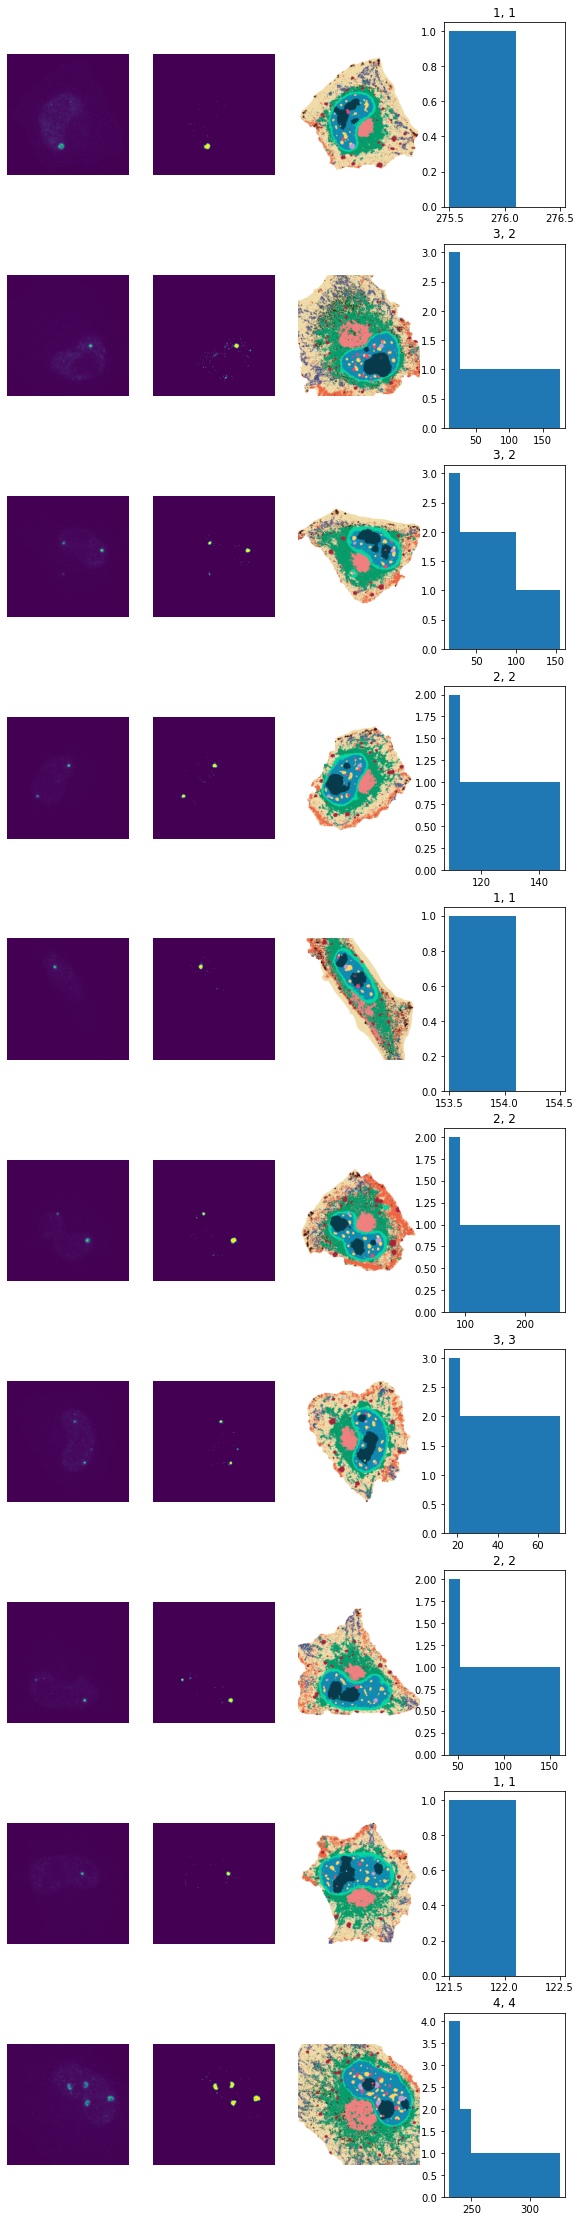

In [209]:
# plot cells with few cajal bodies
selected_cells = adata_object_stats_old.obs[['mapobject_id', 'well_name']][agg_stats['count']['Cajal bodies'] < 5]
fig, axes = plt.subplots(10,4, figsize=(10,40))
for i, obj_id in enumerate(selected_cells[selected_cells['well_name'] == 'K19']['mapobject_id'][:10]):
    intensity_img = mpp_data.get_object_img(int(obj_id), data='mpp', channel_ids=mpp_data.get_channel_ids(['21_COIL']), img_size=400)
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=400)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=400)
    axes[i,0].imshow(intensity_img[:,:,0])
    axes[i,0].axis('off')
    axes[i,1].imshow(cluster_img == 'Cajal bodies')
    axes[i,1].axis('off')
    axes[i,2].imshow(cluster_img_colored)
    axes[i,2].axis('off')
    # plot histogram of sizes
    mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == 'Cajal bodies') & (object_stats['area'] > 10)
    axes[i,3].set_title(f"{len(object_stats[mask]['area'])}, {object_stats[mask]['area'].agg(thresholded_count)}")
    axes[i,3].hist(object_stats[mask]['area'], cumulative=-1, density=False)

In [7]:
from copy import copy

def plot_object_stats(adata, group_key, features=None, clusters=None, figsize_mult=(2, 2), **kwargs):
    """Compare objects stats of groups in group_key.

    Uses stats in adata.obsm['object_stats_agg'], resulting from calling extr.get_object_stats()
    Args:
        adata: anndata object with 'object_stats_agg' in obsm
        group_key: categorical value in adata.obs to group by
        features: list of features to display. Must be columns of adata.obsm['object_stats_agg'].
            If None, all features are displayed.
        clusters: list of clusters to display. Must be columns of adata.obsm['object_stats_agg'].
            If None, all clusters are displayed.
        kwargs: passed to sns.boxplot
    """
    agg_stats = deepcopy(adata.obsm["object_stats_agg"])
    if not isinstance(agg_stats.columns, pd.MultiIndex):
        # restore multiindex for easier access
        agg_stats.columns = pd.MultiIndex.from_tuples([tuple(i.split("|")) for i in agg_stats.columns])
    if features is None:
        features = agg_stats.columns.levels[0]
    if clusters is None:
        clusters = agg_stats.columns.levels[1]
    fig, axes = plt.subplots(
        len(clusters),
        len(features),
        figsize=(len(features) * figsize_mult[0], len(clusters) * figsize_mult[1]),
        sharex=True,
        squeeze=False,
    )
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            cluster = clusters[i]
            feature = features[j]
            df = copy(agg_stats[feature])
            df[group_key] = adata.obs[group_key]
            sns.boxplot(data=df, y=cluster, x=group_key, ax=ax, **kwargs)
            ax.set_title(feature)
    plt.tight_layout()